In [1]:
# python imports
import matplotlib.pyplot as plt
import numpy as np
import corner

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# lenstronomy imports
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Workflow.fitting_sequence import FittingSequence
import lenstronomy.Util.param_util as param_util
from lenstronomy.Plots import chain_plot
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Util import constants
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions


In [ ]:
# Data Specifics for DES camera
background_rms = 7.  # background noise per pixel 
exp_time = 90.  # exposure time 
numPix = 45  # cutout pixel size per axis
deltaPix = 0.2637  # pixel size in arcsec
fwhm = 1 # close-ish to g-band fwhm from DES data


In [53]:
# choices for simulation:
theta_E = 3.
ra_source = 0.1
dec_source = 0.1
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
z_lens = 0.5
z_source = 1.5
lensCosmo = LensCosmo(cosmo=cosmo, z_lens=z_lens, z_source=z_source)

# lens model
lens_model_list = ['SIE']
lensModel = LensModel(lens_model_list=lens_model_list, cosmo=cosmo, z_lens=z_lens, z_source=z_source)
lensModelExtensions = LensModelExtensions(lensModel=lensModel)


x_images=[0.0, 2.7, 3.0, -2.4]
y_images=[3.1, -1.5, 0.1, -1.4]
Source size: 0.0012 arcsec
Flux Ratios: [2.51, 2.62, 0.61]


/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_13316/2029486769.py:79: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_sim), origin='lower')


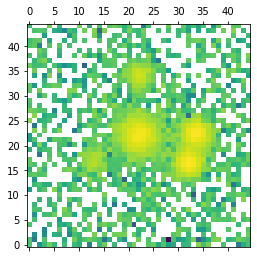

In [55]:
### SIMULATION
## PSF
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

## Lens
# lens model
kwargs_sie = {'theta_E': theta_E, 'center_x': 0, 'center_y': 0, 'e1': 0.05, 'e2': 0.05}
kwargs_lens = [kwargs_sie]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# lens light
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

## Source
# source light
source_model_list = ['SERSIC_ELLIPSE']
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens, sourcePos_x=ra_source, sourcePos_y=dec_source)
print(f'x_images={[round(x, 1) for x in x_image]}') # for reference when making image position 'guesses' later
print(f'y_images={[round(y, 1) for y in y_image]}')


## Point source
# point source magnification
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
# chose a finite source size of emitting 'point source' region
source_size_pc = 10. # Gaussian source size in units of parsec
# convert the units of pc into arcseconds given the redshift of the lens and the cosmology
D_s = lensCosmo.ds
source_size_arcsec = source_size_pc / 10**6 / D_s / constants.arcsec
print(f'Source size: {round(source_size_arcsec,4)} arcsec')

# compute the finite magnification by rendering a grid around the point source position and add up all the flux coming from the extended source in this window
window_size = 0.1  # units of arcseconds
grid_number = 100  # supersampled window (per axis)
mag_finite = lensModelExtensions.magnification_finite(x_pos=x_image, y_pos=y_image, kwargs_lens=kwargs_lens, 
                                                      source_sigma=source_size_arcsec, window_size=window_size,
                                                      grid_number=grid_number)
# compute flux ratios relative to first image
image_amps = np.abs(mag)  # amplitudes of the images (in equivalent counts, not magnitudes)
flux_ratios = image_amps[1:] / image_amps[0]  # flux ratios relative to the first image (required by lenstronomy)
flux_ratio_errors = np.ones_like(flux_ratios)*0.02  # uncertainties in the flux ratios (1-sigma Gaussian error)
flux_ratios_measured = flux_ratios + np.random.normal(0, flux_ratio_errors)

print(f"Flux Ratios: {[round(flux, 2) for flux in flux_ratios_measured]}") # for later reference

# point source model:
point_amp = image_amps * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

## Image Settings
# numerics
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# combine models and settings
imageModel = ImageModel(data_class, psf_class, lens_model_class = lens_model_class, point_source_class=point_source_class,
                                lens_light_model_class=lens_light_model_class,
                                kwargs_numerics=kwargs_numerics)

image_sim = imageModel.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time) 
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms) 
image_sim = image_sim + bkg + poisson # add background noise to image

# update image data with simulated image
kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

# show simulated image
plt.matshow(np.log10(image_sim), origin='lower')
plt.show()
plt.close()

In [64]:
### MODEL
def model(kwargs_lens_initial, kwargs_lens_light_initial, kwargs_ps_initial, flux_ratios_):
    ## Model 
    # model settings defined during simulation, for modeling real images, set models here:
    # set models: 
    #lens_model_list = ['SIE']
    #source_light_model_list = ['SERSIC_ELLIPSE']
    #lens_light_model_list = ['SERSIC_ELLIPSE']
    #point_source_list = ['LENSED_POSITION']

    # combine models 
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_list,
                    'additional_images_list': [False],
                   }  

    # numerics was set during simulation, but when modeling from image, set numerics here:                      
    #kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

    ## Constraints
    # tell constraints how to solve based on the number of images 
    kwargs_constraints = {'num_point_source_list': [len(x_images)],
                          'solver_type': 'NONE'}
    
    ## Image Data
    # with simulation, there is only one band. For real data, add bands here and to multi_band_list
    image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
    multi_band_list = [image_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear', 
                         'flux_ratios': flux_ratios_initial, 
                         'flux_ratio_errors': flux_ratio_errors,
                         'ra_image_list': [x_images], 'dec_image_list': [y_images]
                        }

    ## Parameters
    # lens
    # note: I like using the empty lists and appending them to keep lens model and shear separate
    kwargs_lens_fixed = [{}]
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    # lens model
    kwargs_lens_init.append(kwargs_lens_initial) 
    kwargs_lens_sigma.append({'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_lens.append({'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -1., 'center_y': -1})
    kwargs_upper_lens.append({'theta_E': 5, 'e1': 0.5, 'e2': 0.5,  'center_x': 1., 'center_y': 1})

    # lens light
    kwargs_lens_light_fixed = [{}]
    kwargs_lens_light_init = [kwargs_lens_light_initial]
    kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
    kwargs_lower_lens_light = [{'R_sersic': 0.05, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -1, 'center_y': -1}]
    kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 1, 'center_y': 1}]

    # point source image positions
    kwargs_ps_fixed = [{}]
    kwargs_ps_init = [kwargs_ps_initial]
    kwargs_ps_sigma = [{'ra_image': [0.02] * len(x_image), 'dec_image': [0.02] * len(y_image)}]
    kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]
    kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]

    # Source Size
    # If you want to keep the source size fixed during the fitting, outcomment the line below.
    kwargs_special_fixed = {}
    kwargs_special_init = {}
    kwargs_special_sigma = {}
    kwargs_lower_special = {}
    kwargs_upper_special = {}
    
    # If you want to keep the source size fixed during the fitting, outcomment the line below.
    kwargs_special_fixed['source_size'] = source_size_arcsec
    kwargs_special_init['source_size'] = source_size_arcsec
    kwargs_special_sigma['source_size'] = source_size_arcsec
    kwargs_lower_special['source_size'] = 0.0001
    kwargs_upper_special['source_size'] = 1
    
    # combine params
    lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]
    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]
    ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]
    special_params = [kwargs_special_init, kwargs_special_sigma, kwargs_special_fixed, kwargs_lower_special, kwargs_upper_special]
    
    kwargs_params = {'lens_model': lens_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params,
                    'special': special_params
                    }

    ## Likelihood
    flux_ratio_likelihood = True  # modeling the flux ratios of the images
    image_position_likelihood = True # if you want to evaluate likelihood of image positions

    kwargs_flux_compute = {'source_type': 'INF',  # you can either chose 'INF' which is a infinetesimal source sice, 'GAUSSIAN' or 'TORUS'
                       'window_size': window_size, # window size to compute the finite source magnification (only when 'GAUSSIAN' or 'TORUS' are chosen.)
                       'grid_number': grid_number}  # number of grid points (per axis) to compute the extended source surface brightness within 
    

    kwargs_likelihood = {'check_bounds': True,
                         'force_no_add_image': False,
                         'source_marg': False,
                         'image_position_uncertainty': 0.004,
                         'check_matched_source_position': True,
                         'source_position_tolerance': 0.01,
                         'source_position_sigma': 0.005,
                         'source_position_likelihood': False,
                         'flux_ratio_likelihood': flux_ratio_likelihood,  
                         'kwargs_flux_compute': kwargs_flux_compute,  # source_type='INF' will lead to point source
                         } # see lenstronomy_extensions notebook: catalogue modelling for more info on these

    ### Fitting
    ## PSO
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}]]
    chain_list_pso = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    args_result = fitting_seq.param_class.kwargs2args(**kwargs_result)
    for i in range(len(chain_list_pso)):
        chain_plot.plot_chain_list(chain_list_pso, i)

    ## MCMC
    fitting_kwargs_list = [['MCMC', {'n_burn': 200, 'n_run': 600, 'walkerRatio': 10,'sigma_scale': 0.1}]]
    chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    chain_plot.plot_chain_list(chain_list_mcmc)
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list_mcmc[0]
    param = Param(kwargs_model, kwargs_fixed_lens=kwargs_lens_fixed, kwargs_fixed_ps=kwargs_ps_fixed, kwargs_fixed_special=kwargs_special_fixed, 
               kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
    num_param, param_list = param.num_param() # the number of non-linear parameters and their names
    
    # specifying which parameters to show on the corner plot
    mcmc_new_list = []
    labels_new = [r"$\theta_E$"]
    
    for i in range(len(samples_mcmc)):
        # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
        kwargs_out = param.args2kwargs(samples_mcmc[i])
        kwargs_lens_out, kwargs_special_out, kwargs_ps_out = kwargs_out['kwargs_lens'], kwargs_out['kwargs_special'], kwargs_out['kwargs_ps']

         # compute 'real' image position
        ra_pos, dec_pos = kwargs_ps_out[0]['ra_image'], kwargs_ps_out[0]['dec_image']
        
        theta_E = kwargs_lens_out[0]['theta_E']
        new_chain = [theta_E]
        
        for i in range(len(ra_pos)):
            new_chain.append(ra_pos[i])
            labels_new.append('ra_image_'+str(i))
            
        for i in range(len(dec_pos)): 
            new_chain.append(dec_pos[i])
            labels_new.append('dec_image_'+str(i))
        
        mag = lensModel.magnification(ra_pos, dec_pos, kwargs_lens_out)
        for i in range(len(ra_pos)-1):
            alphabet=['B', 'C', 'D']
            labels_new.append('Flux: '+alphabet[i]+'/A')
            flux_ratio_fit = mag[i+1]/mag[0]
            new_chain.append(flux_ratio_fit)
            
        mcmc_new_list.append(np.array(new_chain))
    
    plot = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True)
    
    

In [62]:
# 'guesses' for image position based on simulation
x_images=[0.0, 2.7, 3.0, -2.4]
y_images=[3.1, -1.5, 0.1, -1.4]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 3, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0}
kwargs_lens_light_initial= {'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}
kwargs_ps_initial= {'ra_image': x_images, 'dec_image': y_images}

# 'guesses' for image magnitudes?
flux_ratios_initial = [2.51, 2.62, 0.61]


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-1.031005810286814 reduced X^2 of best position
-1033.0678219073877 logL
2004.0 effective number of data points
[{'theta_E': 2.992791982806509, 'e1': 0.06296287182703737, 'e2': 0.06461208232339971, 'center_x': -0.013533435078337822, 'center_y': -0.028416358608015106}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.9031165987825683, 'n_sersic': 2.026030785376286, 'e1': 0.004818267474033685, 'e2': -0.03340667997016879, 'center_x': 0.014542717363246044, 'center_y': -0.017385782152254295}] lens light result
[{'ra_image': array([-0.00489632,  2.66751699,  3.03584864, -2.3708994 ]), 'dec_image': array([ 3.1504006 , -1.49366456,  0.08894669, -1.4012848 ]), 'point_amp': array([1., 1., 1., 1.])}] point source result
{} special param result
126.76153373718262 time used for  PSO


100%|█████████████████████████████████████████| 800/800 [07:46<00:00,  1.71it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
467.57158613204956 time taken for MCMC sampling


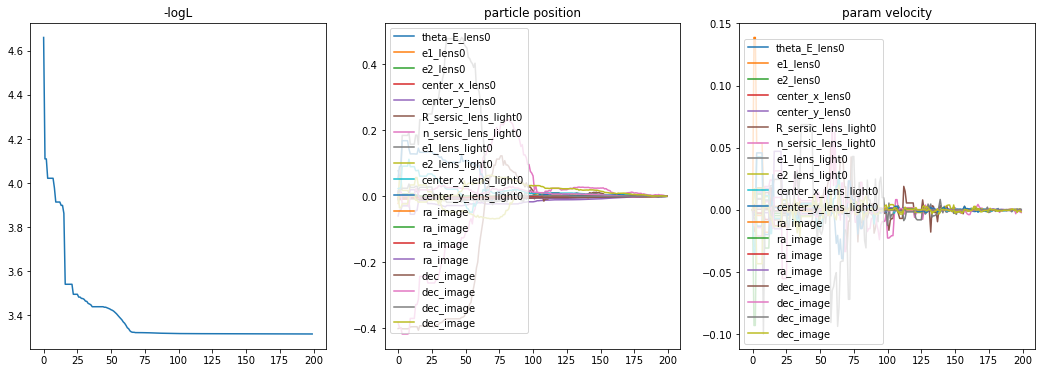

<Figure size 432x288 with 0 Axes>

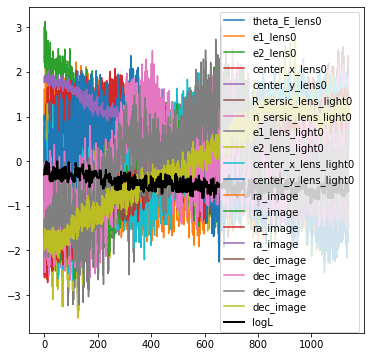

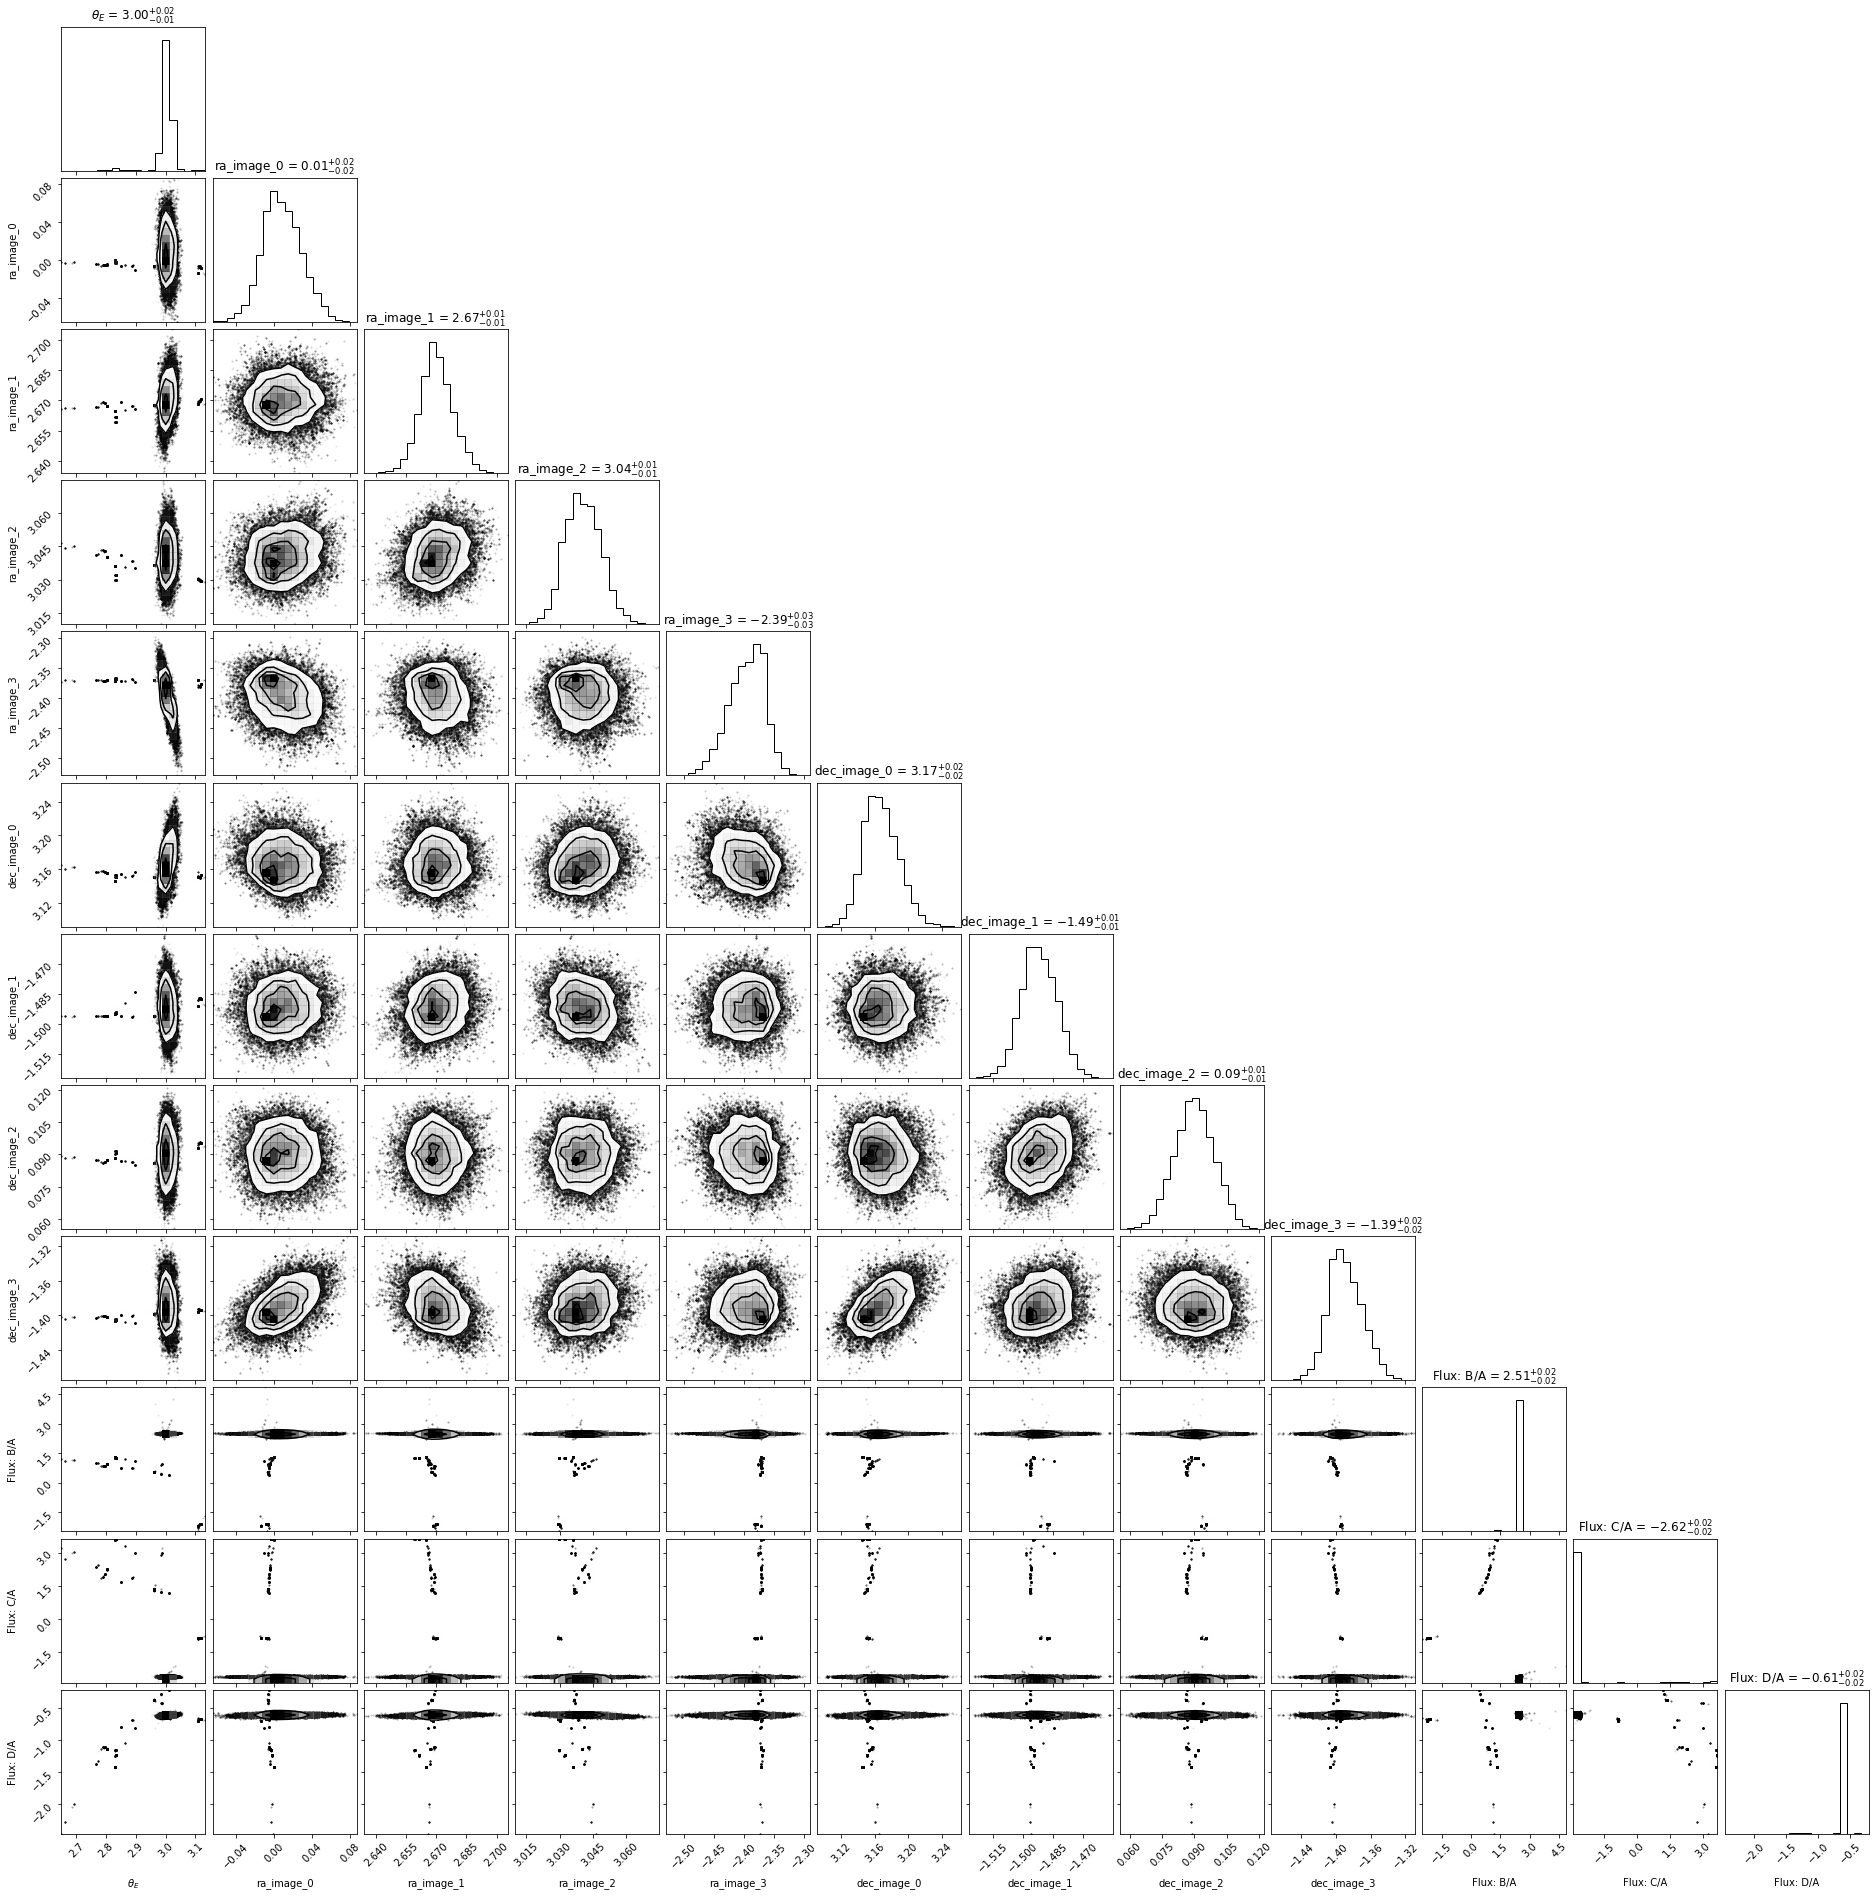

In [63]:
# run model
model(kwargs_lens_initial, kwargs_lens_light_initial, kwargs_ps_initial, flux_ratios_initial)